In [1]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Create spark version
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.3.1'
spark_version = 'spark-3.3.2'
os.environ['SPARK_VERSION']=spark_version

In [3]:
# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease
Get:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Fetched 222 kB in 6s (38.5 kB/s)
Reading package lists... Done


In [4]:
# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

In [5]:
# Import findspark and initialize. 
import findspark
findspark.init()

In [6]:
# Start Spark session
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, countDistinct
spark = SparkSession.builder.appName("ObesityRiskFactors").getOrCreate()

In [7]:
# Import google drive in colab
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
# Read CSV from google drive
behavioral_risk_df = spark.read.csv('gdrive/My Drive/Nutrition__Physical_Activity__and_Obesity_-_Behavioral_Risk_Factor_Surveillance_System.csv', header=True, inferSchema = True)


In [9]:
# Show data columns and types
behavioral_risk_df.printSchema()

root
 |-- YearStart: integer (nullable = true)
 |-- YearEnd: integer (nullable = true)
 |-- LocationAbbr: string (nullable = true)
 |-- LocationDesc: string (nullable = true)
 |-- Datasource: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Topic: string (nullable = true)
 |-- Question: string (nullable = true)
 |-- Data_Value_Unit: string (nullable = true)
 |-- Data_Value_Type: string (nullable = true)
 |-- Data_Value: double (nullable = true)
 |-- Data_Value_Alt: double (nullable = true)
 |-- Data_Value_Footnote_Symbol: string (nullable = true)
 |-- Data_Value_Footnote: string (nullable = true)
 |-- Low_Confidence_Limit: double (nullable = true)
 |-- High_Confidence_Limit : double (nullable = true)
 |-- Sample_Size: integer (nullable = true)
 |-- Total: string (nullable = true)
 |-- Age(years): string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Income: string (nullable = true)
 |-- Race/Ethnicity: string (nul

In [10]:
# Show unique Year values
behavioral_risk_df.select("YearStart","YearEnd").distinct().collect()

[Row(YearStart=2015, YearEnd=2015),
 Row(YearStart=2014, YearEnd=2014),
 Row(YearStart=2020, YearEnd=2020),
 Row(YearStart=2019, YearEnd=2019),
 Row(YearStart=2012, YearEnd=2012),
 Row(YearStart=2016, YearEnd=2016),
 Row(YearStart=2011, YearEnd=2011),
 Row(YearStart=2013, YearEnd=2013),
 Row(YearStart=2018, YearEnd=2018),
 Row(YearStart=2017, YearEnd=2017),
 Row(YearStart=2021, YearEnd=2021)]

In [ ]:
#unique_list = []
#for c in behavioral_risk_df:
  #unique_list.append({"column":c, "unique_values":len(behavioral_risk_df[c].unique())})
#unique_list_df = pd.DataFrame(unique_list)
#unique_list_df = unique_list_df.set_index("column", drop=True)
#unique_list_df

In [12]:
# Remove unwanted columns
behavioral_risk_df = behavioral_risk_df.drop(*('YearEnd', 'LocationAbbr', 'Datasource',
       'Class', 'Topic', 'Data_Value_Unit', 'Data_Value_Type',
       'Data_Value_Alt', 'Data_Value_Footnote_Symbol',
       'Data_Value_Footnote', 'Low_Confidence_Limit', 'High_Confidence_Limit ',
       'Sample_Size', 'Total', 'Age(years)', 'Education', 'Gender', 'Income',
       'Race/Ethnicity', 'GeoLocation', 'ClassID', 'TopicID', 'QuestionID',
       'DataValueTypeID', 'LocationID', 'StratificationCategory1',
       'StratificationCategoryId1', 'StratificationID1'))
behavioral_risk_df.show()

+---------+--------------------+--------------------+----------+--------------------+
|YearStart|        LocationDesc|            Question|Data_Value|     Stratification1|
+---------+--------------------+--------------------+----------+--------------------+
|     2020|            National|Percent of adults...|      30.6|            Hispanic|
|     2014|                Guam|Percent of adults...|      29.3|High school graduate|
|     2013|            National|Percent of adults...|      28.8|   $50,000 - $74,999|
|     2013|            National|Percent of adults...|      32.7|   Data not reported|
|     2015|            National|Percent of adults...|      26.6|   Less than $15,000|
|     2015|                Guam|Percent of adults...|      27.4|            Hispanic|
|     2012|             Wyoming|Percent of adults...|      48.5|American Indian/A...|
|     2012|District of Columbia|Percent of adults...|      31.6|Less than high sc...|
|     2015|         Puerto Rico|Percent of adults...| 

In [14]:
#df = df.filter((df.A != 'NA') & (df.B != 'NA') & (df.C != 'NA'))

In [13]:
# Drop National from LocationDesc and Total from Stratification1
behavioral_risk_df = behavioral_risk_df.filter((behavioral_risk_df.LocationDesc != "National") & \
(behavioral_risk_df.Stratification1 != "Total"))
behavioral_risk_df.show()

+---------+--------------------+--------------------+----------+--------------------+
|YearStart|        LocationDesc|            Question|Data_Value|     Stratification1|
+---------+--------------------+--------------------+----------+--------------------+
|     2014|                Guam|Percent of adults...|      29.3|High school graduate|
|     2015|                Guam|Percent of adults...|      27.4|            Hispanic|
|     2012|             Wyoming|Percent of adults...|      48.5|American Indian/A...|
|     2012|District of Columbia|Percent of adults...|      31.6|Less than high sc...|
|     2015|         Puerto Rico|Percent of adults...|      38.1|   $25,000 - $34,999|
|     2011|             Alabama|Percent of adults...|      35.2|             25 - 34|
|     2015|                Guam|Percent of adults...|      30.5|High school graduate|
|     2015|        Rhode Island|Percent of adults...|      40.2|            Hispanic|
|     2012|             Wyoming|Percent of adults...| 

In [14]:
# Drop null from Data_Value
behavioral_risk_df = behavioral_risk_df.filter("NOT Data_Value is NULL")
behavioral_risk_df.show()

+---------+--------------------+--------------------+----------+--------------------+
|YearStart|        LocationDesc|            Question|Data_Value|     Stratification1|
+---------+--------------------+--------------------+----------+--------------------+
|     2014|                Guam|Percent of adults...|      29.3|High school graduate|
|     2015|                Guam|Percent of adults...|      27.4|            Hispanic|
|     2012|             Wyoming|Percent of adults...|      48.5|American Indian/A...|
|     2012|District of Columbia|Percent of adults...|      31.6|Less than high sc...|
|     2015|         Puerto Rico|Percent of adults...|      38.1|   $25,000 - $34,999|
|     2011|             Alabama|Percent of adults...|      35.2|             25 - 34|
|     2015|                Guam|Percent of adults...|      30.5|High school graduate|
|     2015|        Rhode Island|Percent of adults...|      40.2|            Hispanic|
|     2012|             Wyoming|Percent of adults...| 

In [15]:
# View all values for YearStart
behavioral_risk_df.select("YearStart").distinct().collect()

[Row(YearStart=2018),
 Row(YearStart=2015),
 Row(YearStart=2013),
 Row(YearStart=2014),
 Row(YearStart=2019),
 Row(YearStart=2020),
 Row(YearStart=2012),
 Row(YearStart=2016),
 Row(YearStart=2011),
 Row(YearStart=2017),
 Row(YearStart=2021)]

In [16]:
# Import dependencies to convert to Pandas and for training model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import scipy.stats as st
import tensorflow as tf
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:37: UserWarning: You are currently using a nightly version of TensorFlow (2.14.0-dev20230607). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


In [17]:
# Convert spark dataframe to Pandas
behavioral_risk_df = behavioral_risk_df.toPandas()
behavioral_risk_df.head()

,YearStart,LocationDesc,Question,Data_Value,Stratification1
0,2014,Guam,Percent of adults aged 18 years and older who ...,29.3,High school graduate
1,2015,Guam,Percent of adults who achieve at least 150 min...,27.4,Hispanic
2,2012,Wyoming,Percent of adults aged 18 years and older who ...,48.5,American Indian/Alaska Native
3,2012,District of Columbia,Percent of adults aged 18 years and older who ...,31.6,Less than high school
4,2015,Puerto Rico,Percent of adults who engage in no leisure-tim...,38.1,"$25,000 - $34,999"


In [18]:
# Pivot questions to columns
behavioral_risk_df = behavioral_risk_df.pivot(index=["YearStart", "LocationDesc", "Stratification1"], columns=["Question"], values="Data_Value")
behavioral_risk_df.head()

Question                                   Percent of adults aged 18 years and older who have an overweight classification  \
YearStart LocationDesc Stratification1                                                                                       
2011      Alabama      $15,000 - $24,999                                                31.9                                 
                       $25,000 - $34,999                                                35.7                                 
                       $35,000 - $49,999                                                36.6                                 
                       $50,000 - $74,999                                                36.1                                 
                       $75,000 or greater                                               38.5                                 

Question                                   Percent of adults aged 18 years and older who have obesity  \
YearStart LocationDesc Stratification1                                                                  
2011      Alabama      $15,000 - $24,999                                                34.8            
                       $25,000 - $34,999                                                35.8            
                       $35,000 - $49,999                                                32.3            
                       $50,000 - $74,999                                                34.1            
                       $75,000 or greater                                               28.8            

Question                                   Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination)  \
YearStart LocationDesc Stratification1                                                                                                                                                                                                            
2011      Alabama      $15,000 - $24,999                                                36.7                                                                                                                                                      
                       $25,000 - $34,999                                                39.3                                                                                                                                                      
                       $35,000 - $49,999                                                48.7                                                                                                                                                      
                       $50,000 - $74,999                                                41.3                                                                                                                                                      
                       $75,000 or greater                                               53.5                                                                                                                                                      

Question                                   Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week  \
YearStart LocationDesc Stratification1                                                                                                                                                                                                                                                             
2011      Alabama      $15,000 - $24,999                                                10.9   

In [19]:
# Reset index with year, location, and stratification
behavioral_risk_df = behavioral_risk_df.reset_index()
behavioral_risk_df

Question,YearStart,LocationDesc,Stratification1,Percent of adults aged 18 years and older who have an overweight classification,Percent of adults aged 18 years and older who have obesity,Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week,Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),Percent of adults who engage in muscle-strengthening activities on 2 or more days a week,Percent of adults who engage in no leisure-time physical activity,Percent of adults who report consuming fruit less than one time daily,Percent of adults who report consuming vegetables less than one time daily
0,2011,Alabama,"$15,000 - $24,999",31.9,34.8,36.7,10.9,19.6,20.2,38.6,NaN,NaN
1,2011,Alabama,"$25,000 - $34,999",35.7,35.8,39.3,12.0,25.0,23.4,35.2,NaN,NaN
2,2011,Alabama,"$35,000 - $49,999",36.6,32.3,48.7,16.5,28.3,27.0,27.9,NaN,NaN
3,2011,Alabama,"$50,000 - $74,999",36.1,34.1,41.3,16.4,23.2,28.8,25.6,NaN,NaN
4,2011,Alabama,"$75,000 or greater",38.5,28.8,53.5,21.2,28.5,29.4,20.8,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
14127,2021,Wyoming,"Less than $15,000",31.5,34.9,NaN,NaN,NaN,NaN,37.3,53.3,32.1
14128,2021,Wyoming,Less than high school,38.0,32.7,NaN,NaN,NaN,NaN,36.7,45.6,24.1
14129,2021,Wyoming,Male,41.2,32.4,NaN,NaN,NaN,NaN,20.5,45.4,21.2
14130,2021,Wyoming,Non-Hispanic White,36.6,31.3,NaN,NaN,NaN,NaN,22.3,42.5,18.1


In [20]:
# Filter for only years that asked physical activity questions
behavioral_risk_df = behavioral_risk_df.loc[behavioral_risk_df["YearStart"].isin([2011,2013,2015,2017,2019])]
behavioral_risk_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6359 entries, 0 to 11523
Data columns (total 12 columns):
 #   Column                                                                                                                                                                                                                                                 Non-Null Count  Dtype  
---  ------                                                                                                                                                                                                                                                 --------------  -----  
 0   YearStart                                                                                                                                                                                                                                              6359 non-null   int64  
 1   LocationDesc                                               

In [21]:
# Drop fruit and vegetable questions
behavioral_risk_df = behavioral_risk_df.drop(columns=["Percent of adults who report consuming fruit less than one time daily","Percent of adults who report consuming vegetables less than one time daily"])

In [22]:
# Drop any NaN's
behavioral_risk_df = behavioral_risk_df.dropna()
behavioral_risk_df.head()

Question,YearStart,LocationDesc,Stratification1,Percent of adults aged 18 years and older who have an overweight classification,Percent of adults aged 18 years and older who have obesity,Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week,Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),Percent of adults who engage in muscle-strengthening activities on 2 or more days a week,Percent of adults who engage in no leisure-time physical activity
0,2011,Alabama,"$15,000 - $24,999",31.9,34.8,36.7,10.9,19.6,20.2,38.6
1,2011,Alabama,"$25,000 - $34,999",35.7,35.8,39.3,12.0,25.0,23.4,35.2
2,2011,Alabama,"$35,000 - $49,999",36.6,32.3,48.7,16.5,28.3,27.0,27.9
3,2011,Alabama,"$50,000 - $74,999",36.1,34.1,41.3,16.4,23.2,28.8,25.6
4,2011,Alabama,"$75,000 or greater",38.5,28.8,53.5,21.2,28.5,29.4,20.8


In [23]:
# Isolate obesity question
X = behavioral_risk_df.drop(columns=["Percent of adults aged 18 years and older who have obesity"])
y = behavioral_risk_df["Percent of adults aged 18 years and older who have obesity"]

In [24]:
# Get dummies to encode demographic categories
X = pd.get_dummies(X)
X.head()

,YearStart,Percent of adults aged 18 years and older who have an overweight classification,Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week,Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),Percent of adults who engage in muscle-strengthening activities on 2 or more days a week,Percent of adults who engage in no leisure-time physical activity,LocationDesc_Alabama,LocationDesc_Alaska,LocationDesc_Arizona,...,Stratification1_Hawaiian/Pacific Islander,Stratification1_High school graduate,Stratification1_Hispanic,"Stratification1_Less than $15,000",Stratification1_Less than high school,Stratification1_Male,Stratification1_Non-Hispanic Black,Stratification1_Non-Hispanic White,Stratification1_Other,Stratification1_Some college or technical school
0,2011,31.9,36.7,10.9,19.6,20.2,38.6,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2011,35.7,39.3,12.0,25.0,23.4,35.2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2011,36.6,48.7,16.5,28.3,27.0,27.9,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2011,36.1,41.3,16.4,23.2,28.8,25.6,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2011,38.5,53.5,21.2,28.5,29.4,20.8,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)


# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [26]:
# Create optimized model
optimized_model = tf.keras.models.Sequential()
optimized_model.add(tf.keras.layers.Dense(units=64, activation="leaky_relu", input_dim=87))
optimized_model.add(tf.keras.layers.Dense(units=32, activation="leaky_relu"))
optimized_model.add(tf.keras.layers.Dense(units=16, activation="leaky_relu"))
optimized_model.add(tf.keras.layers.Dense(units=8, activation="relu"))
optimized_model.add(tf.keras.layers.Dense(units=4, activation="relu"))
optimized_model.add(tf.keras.layers.Dense(units=1))
opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
optimized_model.compile(loss="mse", optimizer=opt, metrics=[tf.keras.metrics.MeanAbsolutePercentageError(), tf.keras.metrics.RootMeanSquaredError()])

In [27]:
# Model summary
optimized_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                5632      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 4)                 36        
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                                 
Total params: 8417 (32.88 KB)
Trainable params: 8417 (32

In [28]:
# Train the model
optimized_model_fit = optimized_model.fit(X_train_scaled, y_train, epochs=1500, validation_data=(X_test_scaled, y_test))

Epoch 1/1500
158/158 [==============================] - 3s 11ms/step - loss: 943.8924 - mean_absolute_percentage_error: 99.7723 - root_mean_squared_error: 30.7228 - val_loss: 941.1871 - val_mean_absolute_percentage_error: 99.7169 - val_root_mean_squared_error: 30.6788
Epoch 2/1500
158/158 [==============================] - 1s 6ms/step - loss: 941.4921 - mean_absolute_percentage_error: 99.6296 - root_mean_squared_error: 30.6837 - val_loss: 938.2875 - val_mean_absolute_percentage_error: 99.5454 - val_root_mean_squared_error: 30.6315
Epoch 3/1500
158/158 [==============================] - 1s 5ms/step - loss: 938.1036 - mean_absolute_percentage_error: 99.4245 - root_mean_squared_error: 30.6285 - val_loss: 934.3367 - val_mean_absolute_percentage_error: 99.3074 - val_root_mean_squared_error: 30.5669
Epoch 4/1500
158/158 [==============================] - 1s 6ms/step - loss: 933.6362 - mean_absolute_percentage_error: 99.1568 - root_mean_squared_error: 30.5555 - val_loss: 929.3842 - val_mean_a

In [39]:
# Prepare predictions and true values for R-Square value
y_pred = optimized_model.predict(X_test_scaled)
y_true = y_test.values.reshape(-1, 1)

40/40 [==============================] - 0s 1ms/step


In [40]:
# Get R-Square value
metric = tfa.metrics.r_square.RSquare()
metric.update_state(y_true, y_pred)
result = metric.result()
result.numpy()

0.8759939

In [41]:
# Get standard deviation of target variable y_test
print(f"Target variable standard deviation is {y_test.std()}")

Target variable standard deviation is 7.147490063653561


In [32]:
# Evaluate model mean squared error loss, root mean squared error and mean absolute percentage error
test_results = optimized_model.evaluate(X_test_scaled, y_test, verbose=2)

40/40 - 0s - loss: 10.9808 - mean_absolute_percentage_error: 8.3610 - root_mean_squared_error: 3.3137 - 100ms/epoch - 3ms/step


In [33]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(optimized_model_fit.history, index=range(1,len(optimized_model_fit.history["loss"])+1))

<Axes: >

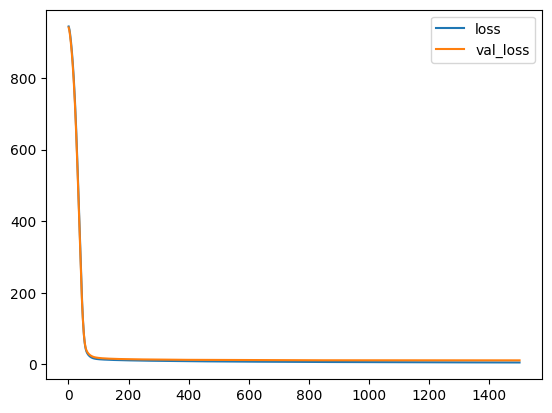

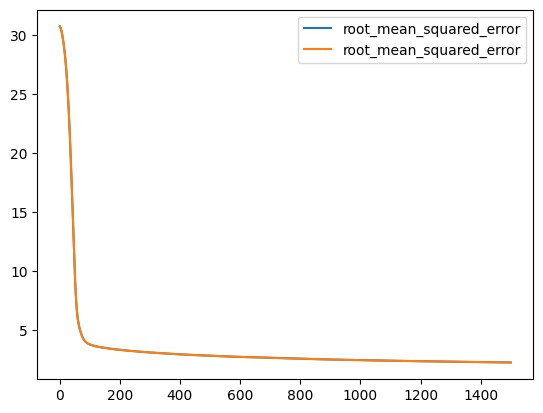

In [34]:
# Plot the mean squared error loss and root mean squared error
history_df.plot(y=["loss","val_loss"])
history_df.plot(y=["root_mean_squared_error","root_mean_squared_error"])

In [42]:
# Export model to HDF5 file
optimized_model.save("Obesity_Prediction_opt.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3086: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [47]:
# Load model
obesity_model = tf.keras.models.load_model("gdrive/My Drive/Obesity_Prediction_r2_832.h5")

In [49]:
# Import hypothetical data to see what the predictions are
hypothetical_df = pd.read_csv("gdrive/My Drive/Hypothetical_Data.csv")
hypothetical_df

,YearStart,Percent of adults aged 18 years and older who have an overweight classification,Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week,Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),Percent of adults who engage in muscle-strengthening activities on 2 or more days a week,Percent of adults who engage in no leisure-time physical activity,LocationDesc_Alabama,LocationDesc_Alaska,LocationDesc_Arizona,...,Stratification1_Hawaiian/Pacific Islander,Stratification1_High school graduate,Stratification1_Hispanic,"Stratification1_Less than $15,000",Stratification1_Less than high school,Stratification1_Male,Stratification1_Non-Hispanic Black,Stratification1_Non-Hispanic White,Stratification1_Other,Stratification1_Some college or technical school
0,2023,35,50,18,33,30,20,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,2023,35,50,18,33,30,20,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2023,35,50,18,33,30,50,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2023,35,50,18,33,30,10,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2023,35,50,18,33,30,20,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,2023,35,50,18,33,30,20,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
# Scale the data
X_hyp_scaled = X_scaler.transform(hypothetical_df)
y_hyp = obesity_model.predict(X_hyp_scaled)

1/1 [==============================] - 0s 127ms/step


In [51]:
# Add column to the hypothetical data to show the predictions for each row of data
hypothetical_df["PREDICTION Percent of adults aged 18 years and older who have obesity"] = [y_hyp[x].item() for x in range(len(y_hyp))]
hypothetical_df

,YearStart,Percent of adults aged 18 years and older who have an overweight classification,Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),Percent of adults who achieve at least 150 minutes a week of moderate-intensity aerobic physical activity or 75 minutes a week of vigorous-intensity aerobic physical activity and engage in muscle-strengthening activities on 2 or more days a week,Percent of adults who achieve at least 300 minutes a week of moderate-intensity aerobic physical activity or 150 minutes a week of vigorous-intensity aerobic activity (or an equivalent combination),Percent of adults who engage in muscle-strengthening activities on 2 or more days a week,Percent of adults who engage in no leisure-time physical activity,LocationDesc_Alabama,LocationDesc_Alaska,LocationDesc_Arizona,...,Stratification1_High school graduate,Stratification1_Hispanic,"Stratification1_Less than $15,000",Stratification1_Less than high school,Stratification1_Male,Stratification1_Non-Hispanic Black,Stratification1_Non-Hispanic White,Stratification1_Other,Stratification1_Some college or technical school,PREDICTION Percent of adults aged 18 years and older who have obesity
0,2023,35,50,18,33,30,20,0,0,0,...,0,0,1,0,0,0,0,0,0,32.139103
1,2023,35,50,18,33,30,20,0,0,0,...,0,0,0,0,0,0,0,0,0,34.327301
2,2023,35,50,18,33,30,50,0,0,0,...,0,0,0,0,0,0,0,0,0,43.406380
3,2023,35,50,18,33,30,10,0,0,0,...,0,0,0,0,0,0,0,0,0,37.642815
4,2023,35,50,18,33,30,20,0,0,0,...,0,0,0,0,0,0,0,0,0,18.871492
5,2023,35,50,18,33,30,20,0,0,0,...,0,0,0,0,0,0,0,0,0,38.777611


<Axes: >

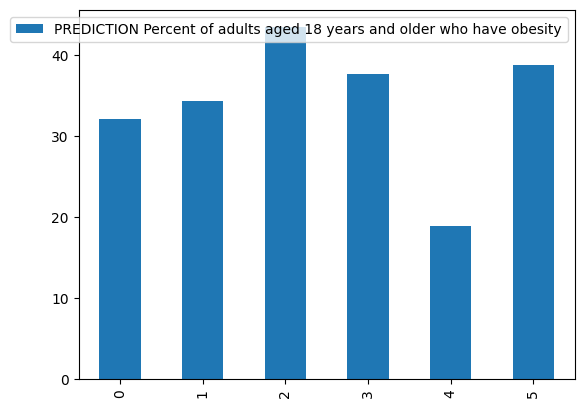

In [52]:
# Index 0 & 1 is lowest income compared to highest income prediction
# Index 2 & 3 is 50% no leisure physical activity compared to 10% no leisure physical activity
# Index 4 & 5 is 18 - 24 age group compared to 45 - 54 age group

hypothetical_df.plot.bar(y="PREDICTION Percent of adults aged 18 years and older who have obesity")